# Dual Digital

The purpose of this notebook is to review dual digital pricing / sensitivities and to introduce realized correlation skew

## Contents
   - [Numerical Integration](#sec1)
       - [Present Value](#sec2)
       - [Partial Derivatives](#sec3)
   - [Realized Parameters](#sec4)
       - [Realized Volatility Skew](#sec5)
       - [Realized Correlation Skew](#sec6)

In [10]:
import imp
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

import importlib
importlib.reload(module)
from module.backtest import Backtest
from module.pricing import DualDigital

# -----
# SET DISPLAY SETTINGS
# -----
pd.set_option('display.width', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<a id='sec1'></a>
## Numerical Integration

<a id='sec2'></a>
### Present Value


The following formula describes how the present value of the product is calculated: $ PV = Probability * CashFlow * Discount $

Where $Discount = e^{-rt} $ and the $Probability$ comes from the integration of the bivariate log-normal distribution (joint probability density function) defined as below

\begin{aligned}
& f_{X, Y}(x, y)=\frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1-\rho^2} x y} \exp \left\{-\frac{1}{2\left(1-\rho^2\right)}\left[\left(\frac{\log x-\mu_1}{\sigma_1}\right)^2+\left(\frac{\log y-\mu_2}{\sigma_2}\right)^2 -2 \rho\left(\frac{\log x-\mu_1}{\sigma_1}\right)\left(\frac{\log y-\mu_2}{\sigma_2}\right)\right]\right\}
\end{aligned}

<br>

For example, for a down down dual digital we have 
$$Probability = \int_{0}^{K_{x}}\int_{0}^{K_{Y}} f(x, y) dy dx $$


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [01:01<00:00,  2.04s/it]


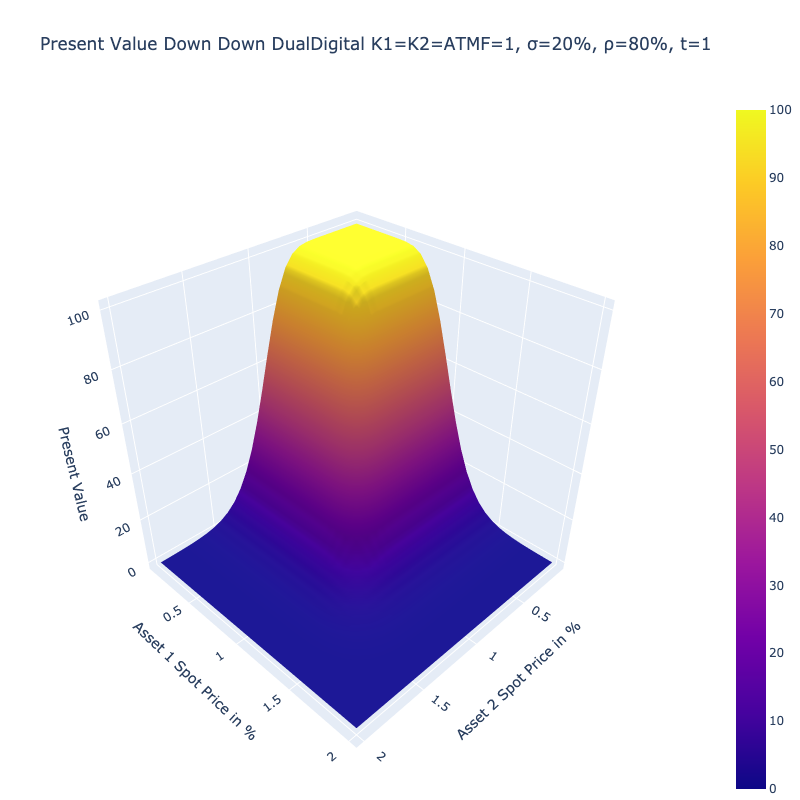

In [3]:
data1 = dict()
for st1 in tqdm(np.linspace(start=0.1, stop=2, num=30)):
    for st2 in np.linspace(start=0.1, stop=2, num=30):
        priceable = DualDigital(
            st1=st1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=st2, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        pv = priceable.get_present_value()
        data1[(st1, st2)] = pv
data1_df = pd.Series(data1).unstack()

fig = go.Figure(data=[go.Surface(x=data1_df.index, y=data1_df.columns, z=data1_df.values)])
fig.update_layout(
    title = "Present Value Down Down DualDigital K1=K2=ATMF=1, σ=20%, ρ=80%, t=1",
    scene = dict(
        xaxis_title='Asset 2 Spot Price in %', 
        yaxis_title='Asset 1 Spot Price in %',
        zaxis_title='Present Value'),
    scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.5, y=1.5, z=1.5)),
    width=800, height=800, margin=dict(r=1, b=1, l=1, t=100))

fig.show('png')

<a id='sec3'></a>
### Partial Derivatives

Delta, Gamma and X Gamma are computed numerically using the below formula

$$ \Delta_{x} = \frac{\partial f}{\partial x} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y\right)-f\left(x, y\right)}{\Delta}$$ 

$$ \Delta_{y} = \frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x, y+\Delta\right)-f\left(x, y\right)}{\Delta}$$ 


$$\Gamma_{x} = \frac{\partial}{\partial x}\frac{\partial f}{\partial x} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y\right)-2f\left(x, y\right)+ f\left(x-\Delta, y\right)}{(\Delta)^{2}}$$

$$\Gamma_{y} = \frac{\partial}{\partial y}\frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x, y+\Delta\right)-2f\left(x, y\right)+ f\left(x, y-\Delta\right)}{(\Delta)^{2}}$$


$$\Gamma_{xy} = \frac{\partial}{\partial x}\frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y+\Delta\right)-f\left(x+\Delta, y\right)- f\left(x, y+\Delta \right) + f\left(x, y\right)}{(\Delta)^{2}}$$

<br>

Using a second-order Taylor series, we can estimate the P&L with the quadratic approximation for Delta, Gamma and X Gamma

$$\Delta f \simeq f_{x}\left(x-x_{0}\right)+f_{y}\left(y-y_{0}\right)+\frac{1}{2} f_{x x}\left(x-x_{0}\right)^{2}+f_{x y}\left(x-x_{0}\right)\left(y-y_{0}\right)+\frac{1}{2} f_{y y}\left(y-y_{0}\right)^{2}$$

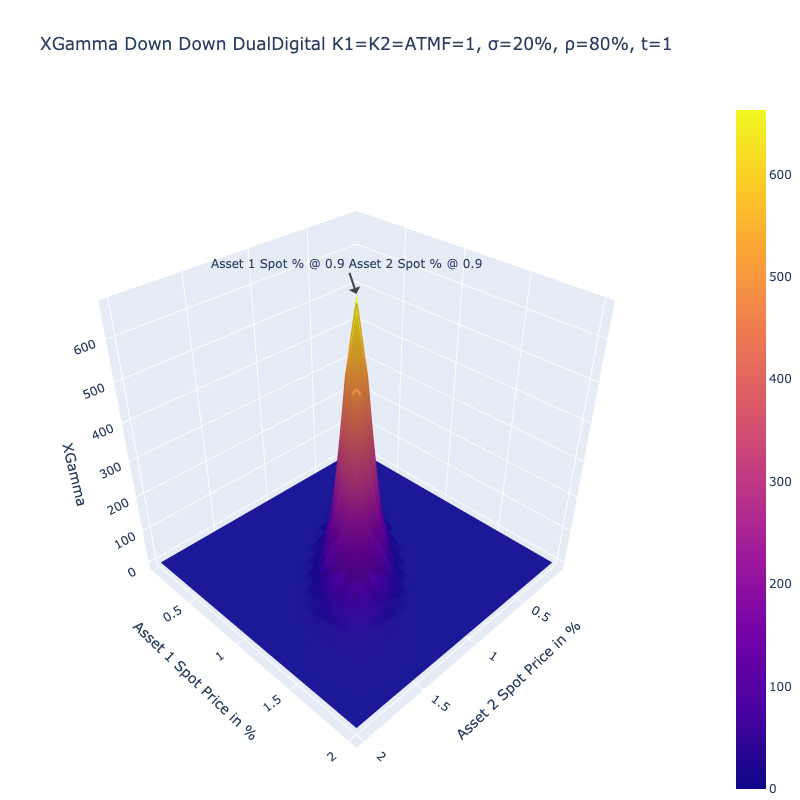

In [13]:
data2 = dict()
for st1 in tqdm(np.linspace(start=0.1, stop=2, num=20)):
    for st2 in np.linspace(start=0.1, stop=2, num=20):
        priceable = DualDigital(
            st1=st1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=st2, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        priceable.calculate_x_gamma()
        pv = priceable.get_present_value()
        greeks = priceable.get_greeks()
        data2[(st1, st2)] = greeks.get('dst1*dst2')
data2_df = pd.Series(data2).unstack()

x_max = np.round(data2_df.max().idxmax(), 2)
y_max = np.round(data2_df.transpose().max().idxmax(), 2)
z_max = np.round(data2_df.max().max())

fig = go.Figure(data=[go.Surface(x=data2_df.index, y=data2_df.columns, z=data2_df.values)])
fig.update_layout(
    title = "XGamma Down Down DualDigital K1=K2=ATMF=1, σ=20%, ρ=80%, t=1",
    scene = dict(
        xaxis_title='Asset 2 Spot Price in %', 
        yaxis_title='Asset 1 Spot Price in %',
        zaxis_title='XGamma',
        annotations=[dict(x=x_max, y=y_max, z=z_max, text=f'Asset 1 Spot % @ {y_max} Asset 2 Spot % @ {x_max}')]),
    scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.5, y=1.5, z=1.5)),
    width=800, height=800, margin=dict(r=1, b=1, l=1, t=100))

fig.show('png')

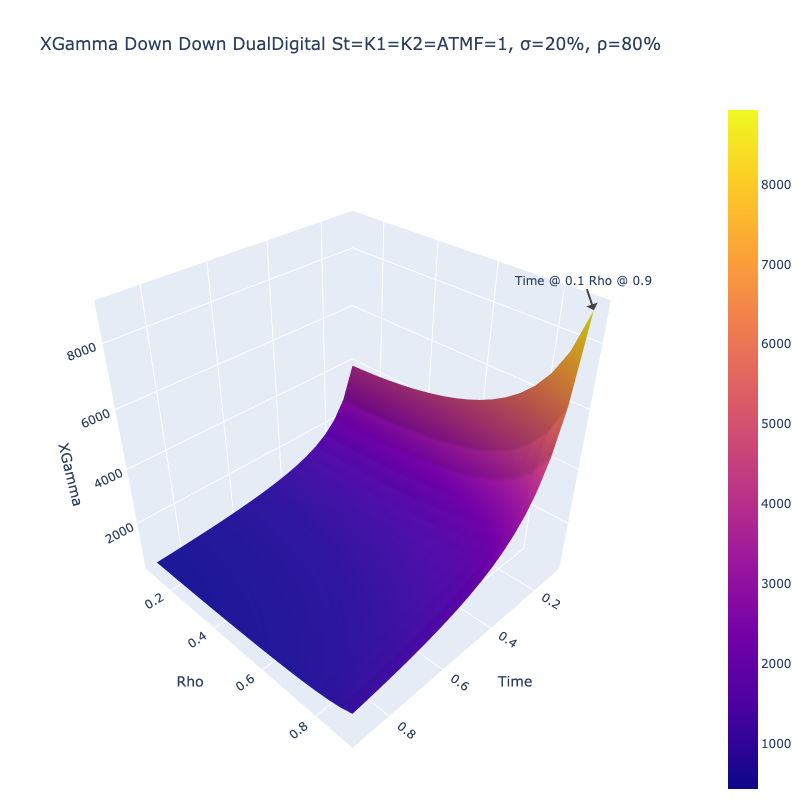

In [18]:
data3 = dict()
for rho in tqdm(np.linspace(start=0.1, stop=0.9, num=20)):
    for t in np.linspace(start=0.1, stop=0.9, num=20):
        priceable = DualDigital(
            st1=1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=1, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=rho, r=0, t=t, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        priceable.calculate_x_gamma()
        pv = priceable.get_present_value()
        greeks = priceable.get_greeks()
        data3[(rho, t)] = greeks.get('dst1*dst2')
data3_df = pd.Series(data3).unstack()

x_max = np.round(data3_df.max().idxmax(), 2)
y_max = np.round(data3_df.transpose().max().idxmax(), 2)
z_max = np.round(data3_df.max().max())

fig = go.Figure(data=[go.Surface(x=data3_df.index, y=data3_df.columns, z=data3_df.values)])
fig.update_layout(
    title = "XGamma Down Down DualDigital St=K1=K2=ATMF=1, σ=20%, ρ=80%",
    scene = dict(
        xaxis_title='Time', 
        yaxis_title='Rho',
        zaxis_title='XGamma',
        annotations=[dict(x=x_max, y=y_max, z=z_max, text=f'Time @ {x_max} Rho @ {y_max}')]),
    scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.5, y=1.5, z=1.5)),
    width=800, height=800, margin=dict(r=1, b=1, l=1, t=100))

fig.show("png")

<a id='sec4'></a>
## Realized Parameters

<a id='sec5'></a>
### TODO ...